<a href="https://colab.research.google.com/github/bellarude/colab/blob/master/RR_decoder_spectraAsDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### *import*

In [3]:
from __future__ import print_function
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import h5py
from keras.models import Model, load_model, Sequential
from keras.layers import Activation, Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D, Reshape, Dense, Flatten, Input, BatchNormalization, ELU, Conv2D, Conv1D
#from keras import backend as K
import tensorflow.keras.backend as K

from keras import layers
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# **Dataset and Label input + processing**

In [4]:
os.environ["KERAS_BACKEND"] = "theano"

K.set_image_data_format('channels_first')

data_import = sio.loadmat('/content/drive/My Drive/nets/dataset_spectra_tot.mat')
labels_import_t1_Cr = sio.loadmat('/content/drive/My Drive/nets/labels_Cr_type1.mat')
#labels_import_t1_Glu = sio.loadmat('/content/drive/My Drive/nets/labels_Glu_type1.mat')
#labels_import_t1_PCho = sio.loadmat('/content/drive/My Drive/nets/labels_PCho_type1.mat')
labels_import_t1_tot = sio.loadmat('/content/drive/My Drive/nets/labels_met_t1.mat')

dataset = data_import['spectra']
labels_t1_Cr = labels_import_t1_Cr['labels_Cr_type1']
#labels_t1_Glu = labels_import_t1_Glu['labels_Glu_type1']
#labels_t1_PCho = labels_import_t1_PCho['labels_PCho_type1']
labels_t1 = labels_import_t1_tot['labels_met_t1']

X_train = dataset[0:25000, :]
X_val = dataset[25000:27500, :]
X_test = dataset[27500:30000, :]

y_train_t1_Cr = labels_t1_Cr[0:25000, :]
y_val_t1_Cr = labels_t1_Cr[25000:27500, :]
y_test_t1_Cr = labels_t1_Cr[27500:30000, :]

# y_train_t1_Glu = labels_t1_Glu[0:25000, :]
# y_val_t1_Glu = labels_t1_Glu[25000:27500, :]
# y_test_t1_Glu = labels_t1_Glu[27500:30000, :]

# y_train_t1_PCho = labels_t1_PCho[0:25000, :]
# y_val_t1_PCho = labels_t1_PCho[25000:27500, :]
# y_test_t1_PCho = labels_t1_PCho[27500:30000, :]

y_train_t1 = labels_t1[0:25000, :]
y_val_t1 = labels_t1[25000:27500, :]
y_test_t1 = labels_t1[27500:30000, :]

print('Train set:')
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
# print('Label t1_Cr  set:')
# print(y_train_t1_Cr.shape)
# print(y_val_t1_Cr.shape)
# print(y_test_t1_Cr.shape)
print('Label t1  set:')
print(y_train_t1.shape)
print(y_val_t1.shape)
print(y_test_t1.shape)


# #reshaping
X_train_rs = np.transpose(X_train, (0, 2, 1))
X_val_rs = np.transpose(X_val, (0, 2, 1))
X_test_rs = np.transpose(X_test, (0, 2, 1))

print('After reshaping: ')
print(X_train_rs.shape)

Train set:
(25000, 2, 1024)
(2500, 2, 1024)
(2500, 2, 1024)
Label t1  set:
(25000, 5)
(2500, 5)
(2500, 5)
After reshaping: 
(25000, 1024, 2)


#### *if desired only one channel*

i.e. only Real or Imag spectrogram dataset

In [ ]:
X_train_rs = X_train_rs[:,0,:,:]
X_val_rs = X_val_rs[:,0,:,:]
X_test_rs = X_test_rs[:,0,:,:]

X_train_rs = np.reshape(X_train_rs, (25000,1,128,32))
X_val_rs = np.reshape(X_val_rs, (2500,1,128,32))
X_test_rs = np.reshape(X_test_rs, (2500,1,128,32))

print('After channel pick up: ')
print(X_train_rs.shape)

After channel pick up: 
(25000, 1, 128, 32)


# **Easier Network - RR**
I want to try simple network to get after big dataset training not to 0 outcome

#### **Net definition**

In [26]:
# input image dimensions
datapoints = 1024
channels = 2
input_shape = (datapoints, channels)
inputs = Input(shape=input_shape)

# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (3),
    'padding': 'same'}

# --- Define poolargs dictionary
poolargs = {
    'pool_size': (2),
    'strides': (2)}

# --- Define lambda functions
conv = lambda x, filters, strides : layers.Conv1D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization(axis=1)(x)
relu = lambda x : layers.ReLU()(x)
maxP = lambda x, pool_size, strides : layers.MaxPooling1D(pool_size=pool_size, strides=strides)(x)

flatten = lambda x : layers.Flatten()(x)
dense = lambda units, x : layers.Dense(units=units)(x)

convBlock = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
convBlock2 = lambda filters, x : convBlock(filters, convBlock(filters, x))
convBlock4 = lambda filters, x : convBlock2(filters, convBlock2(filters, x))

l1 = maxP(convBlock2(64, inputs), **poolargs)
l2 = maxP(convBlock2(128, l1), **poolargs)
l3 = maxP(convBlock2(256, l2), **poolargs)
l4 = maxP(convBlock2(512, l3), **poolargs)
l5 = maxP(convBlock2(1024, l4), **poolargs)

#outputs = relu(dense(4096, dense(512, flatten(l3))))
l6 = relu(dense(512, flatten(l5)))
l7 = relu(dense(248, l6))
outputs = relu(dense(5, l7))

# --- Create model
modelRR = Model(inputs=inputs, outputs=outputs)

# --- Compile model
modelRR.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
    loss = tf.keras.losses.MeanSquaredError(),
    experimental_run_tf_function=False)

print(modelRR.summary())


Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1024, 2)]         0         
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 1024, 64)          448       
_________________________________________________________________
batch_normalization_57 (Batc (None, 1024, 64)          4096      
_________________________________________________________________
re_lu_71 (ReLU)              (None, 1024, 64)          0         
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 1024, 64)          12352     
_________________________________________________________________
batch_normalization_58 (Batc (None, 1024, 64)          4096      
_________________________________________________________________
re_lu_72 (ReLU)              (None, 1024, 64)        

#### **Training RR easier net**

In [29]:
checkpoint_Cr_path = "/content/drive/My Drive/nets/models/RRdecoderFromSpectra_net.best.hdf5"
checkpoint_Cr_dir = os.path.dirname(checkpoint_Cr_path)
checkpoint_Cr = ModelCheckpoint(filepath=checkpoint_Cr_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only= True, mode='min')
callbacks_list_Cr = [checkpoint_Cr]

# selected channel 0 to keep only Re(spectrogram)
modelRR.fit(X_train_rs, y_train_t1, 
            epochs=2, 
            batch_size=20, 
            shuffle=True, 
            validation_data=(X_val_rs, y_val_t1), 
            validation_freq=2,
            callbacks=callbacks_list_Cr, 
            verbose=1)

Epoch 1/2
1250/1250 [==============================] - 48s 38ms/step - loss: 20.8434
Epoch 2/2
1249/1250 [============================>.] - ETA: 0s - loss: 4.2180WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0027s vs `on_test_batch_end` time: 0.0063s). Check your callbacks.

Epoch 00002: val_loss improved from inf to 2.78087, saving model to /content/drive/My Drive/nets/models/RRdecoderFromSpectra_net.best.hdf5
1250/1250 [==============================] - 51s 41ms/step - loss: 4.2167 - val_loss: 2.7809


#### **Testing and output evaluation**

In [10]:
checkpoint_Cr_path = "/content/drive/My Drive/nets/models/RRdecoderFromSpectra_net.best.hdf5"

modelRR.load_weights(checkpoint_Cr_path)
loss = modelRR.evaluate(X_test_rs,  y_test_t1, verbose=2)
print("model, loss:", loss)


79/79 - 2s - loss: 33.3053
model, loss: 33.305267333984375


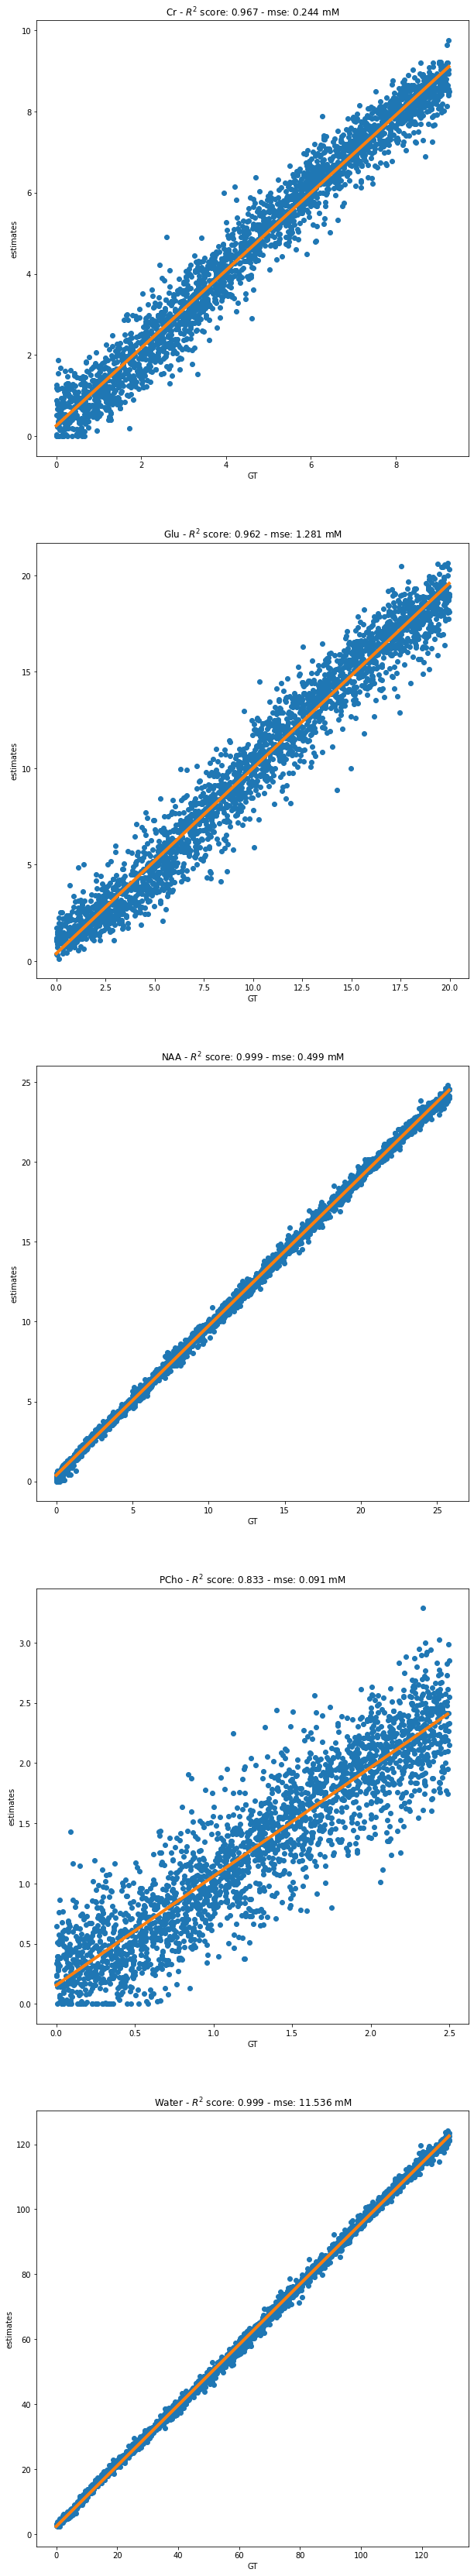

In [30]:
pred = modelRR.predict(X_test_rs)

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()

fig = plt.figure(figsize=(10,60))

plt.subplot(511)
#----------------------------------------------
x = y_test_t1[:,0].reshape(-1,1)
y = pred[:,0]
regr.fit(x, y)
lin = regr.predict(np.arange(0,np.max(y_test_t1[:,0]),0.01).reshape(-1,1))
mse = mean_squared_error(x, y)
r_sq = regr.score(x, y)
#----------------------------------------------
plt.plot(y_test_t1[:,0],pred[:,0],'o')
plt.plot(np.arange(0,np.max(y_test_t1[:,0]),0.01),lin,linewidth=4)
plt.title(r'Cr - $R^2$ score: ' + str(np.round(r_sq, 3)) + ' - mse: ' + str(np.round(mse, 3)) + ' mM'), plt.xlabel('GT'), plt.ylabel('estimates')

plt.subplot(512)
#----------------------------------------------
x = y_test_t1[:,1].reshape(-1,1)
y = pred[:,1]
regr.fit(x, y)
lin = regr.predict(np.arange(0,np.max(y_test_t1[:,1]),0.01).reshape(-1,1))
mse = mean_squared_error(x, y)
r_sq = regr.score(x, y)
#----------------------------------------------
plt.plot(y_test_t1[:,1],pred[:,1],'o')
plt.plot(np.arange(0,np.max(y_test_t1[:,1]),0.01),lin,linewidth=4)
plt.title(r'Glu - $R^2$ score: ' + str(np.round(r_sq, 3)) + ' - mse: ' + str(np.round(mse, 3)) + ' mM'), plt.xlabel('GT'), plt.ylabel('estimates')



plt.subplot(513)
#----------------------------------------------
x = y_test_t1[:,2].reshape(-1,1)
y = pred[:,2]
regr.fit(x, y)
lin = regr.predict(np.arange(0,np.max(y_test_t1[:,2]),0.01).reshape(-1,1))
mse = mean_squared_error(x, y)
r_sq = regr.score(x, y)
#----------------------------------------------
plt.plot(y_test_t1[:,2],pred[:,2],'o')
plt.plot(np.arange(0,np.max(y_test_t1[:,2]),0.01),lin,linewidth=4)
plt.title(r'NAA - $R^2$ score: ' + str(np.round(r_sq, 3)) + ' - mse: ' + str(np.round(mse, 3)) + ' mM'), plt.xlabel('GT'), plt.ylabel('estimates')


plt.subplot(514)
#----------------------------------------------
x = y_test_t1[:,3].reshape(-1,1)
y = pred[:,3]
regr.fit(x, y)
lin = regr.predict(np.arange(0,np.max(y_test_t1[:,3]),0.01).reshape(-1,1))
mse = mean_squared_error(x, y)
r_sq = regr.score(x, y)
#----------------------------------------------
plt.plot(y_test_t1[:,3],pred[:,3],'o')
plt.plot(np.arange(0,np.max(y_test_t1[:,3]),0.01),lin,linewidth=4)
plt.title(r'PCho - $R^2$ score: ' + str(np.round(r_sq, 3)) + ' - mse: ' + str(np.round(mse, 3)) + ' mM'), plt.xlabel('GT'), plt.ylabel('estimates')


plt.subplot(515)
#----------------------------------------------
x = y_test_t1[:,4].reshape(-1,1)
y = pred[:,4]
regr.fit(x, y)
lin = regr.predict(np.arange(0,np.max(y_test_t1[:,4]),0.01).reshape(-1,1))
mse = mean_squared_error(x, y)
r_sq = regr.score(x, y)
#----------------------------------------------
plt.plot(y_test_t1[:,4],pred[:,4],'o')
plt.plot(np.arange(0,np.max(y_test_t1[:,4]),0.01),lin,linewidth=4)
plt.title(r'Water - $R^2$ score: ' + str(np.round(r_sq, 3)) + ' - mse: ' + str(np.round(mse, 3)) + ' mM'), plt.xlabel('GT'), plt.ylabel('estimates')

plt.show()

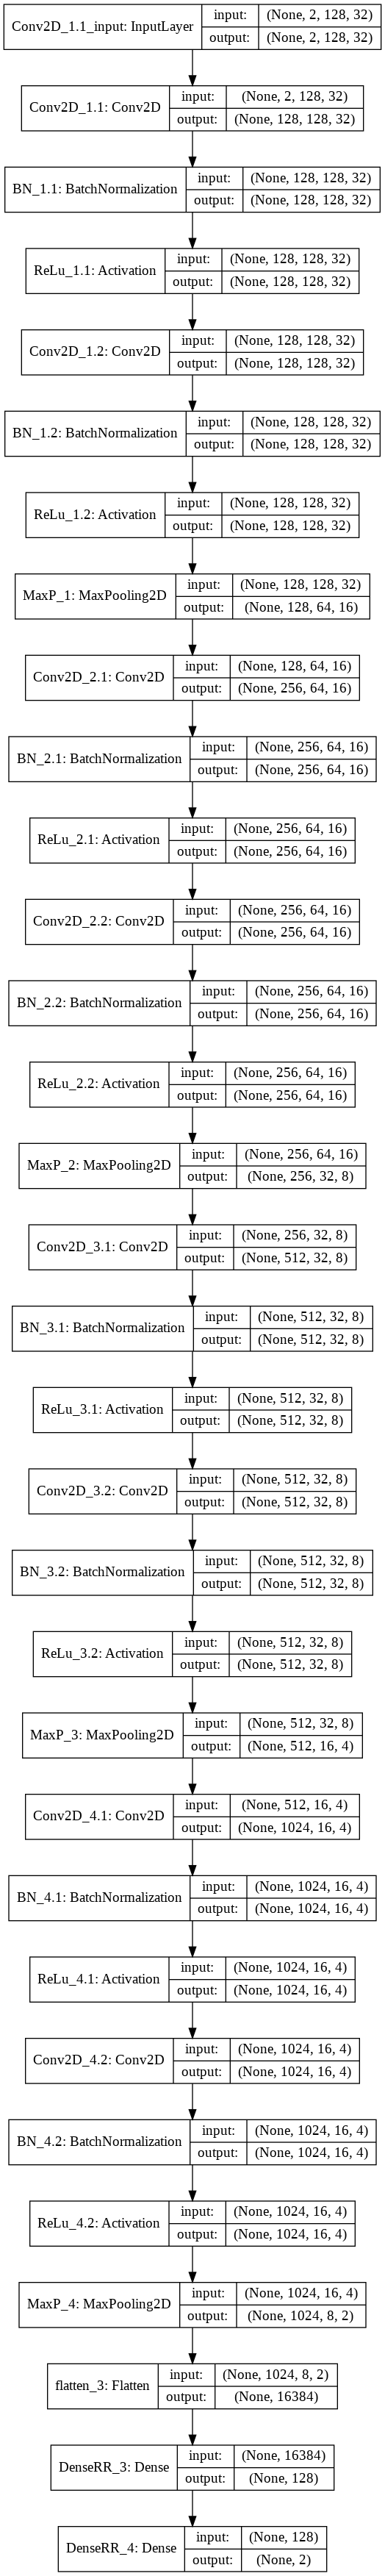

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(modelRR, to_file='model_plot.png', show_shapes=True, show_layer_names=True)